In [1]:
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import line_profiler

from usgs.helpers import *
from usgs.imputation.imputation import *
from pymongo import MongoClient
from numpy.lib.stride_tricks import as_strided

client = MongoClient("localhost", 27017)
db = client['usgs']

plt.rcParams['image.cmap'] = 'viridis'
%matplotlib inline

In [225]:
def extreme_values(y, continuity, high = True, low = True):
    n = y.size // 2
    res = y.copy()
    
    z = np.sort(np.abs(y))
    dz = z[1:] - z[:-1]
    
    if low:
        mask_min = dz[:n][::-1] > continuity
        if mask_min.sum() > 0:
            i_min = n - np.argmax(mask_min)
            thr_min = 0.5*(z[i_min] + z[i_min - 1])
        else:
            thr_min = z[0] - 1
    else:
        thr_min = z[0] - 1
        
    if high:
        mask_max = dz[n:] > continuity
        if mask_max.sum() > 0:
            i_max = n + np.argmax(mask_max)
            thr_max = 0.5*(z[i_max] + z[i_max + 1])
        else:
            thr_max = z[-1] + 1   
    else:
        thr_max = z[-1] + 1  
    
    idx = (res < thr_min) | (res > thr_max)
    return idx


def detect_spikes(y, dt, min_amp = 0.5, thr = 0.25):
    mask = np.zeros(y.size, dtype = bool)
    for i in range(1, y.size - 1):
        dL = ( y[i] - y[i-1] ) / dt * 3600
        dR = ( y[i] - y[i+1] ) / dt * 3600                 
        if ( dL * dR > 0 ) and ( min(abs(dL), abs(dR)) > min_amp ):
#          ( abs(abs(dL) - abs(dR)) < thr * max(abs(dL), abs(dR)) ) :
            mask[i] = True            
    return mask


def detect_consts(y):
    dy = np.hstack([1, y[1:] - y[:-1]])
    return dy != 0
        

def fix_spikes(y, mask):
    z = y.copy()
    idx = np.where(mask)[0]
    z[idx] = 0.5*(y[idx - 1] + y[idx + 1])
    return z


def rolling_window_1d(a, window_size, stride = 1, padded = True):
    itemsize = a.dtype.itemsize
    k = window_size // 2
    if padded:
        output = np.hstack([np.zeros(k + window_size % 2) + a[0], a, np.zeros(k) + a[-1]])
    else:
        output = a
    return as_strided(output, 
                      strides = (stride*itemsize, itemsize), 
                      shape   = ((output.size - window_size) // stride, window_size))


def erosion_filter_1d(y, k):
    samples = rolling_window_1d(y, k)
    return np.min(samples, axis = 1)


def dilation_filter_1d(y, k):
    samples = rolling_window_1d(y, k)
    return np.max(samples, axis = 1)


def median_filter_1d(y, k):
    samples = rolling_window_1d(y, k)
    return np.median(samples, axis = 1)


def box_filter_1d(y, k):
    kernel = np.ones(k) / k
    return np.convolve(y, kernel, mode = 'same')


def gaussian_filter_1d(y, k, sigma):
    kernel = np.exp(-0.5*((np.arange(k) - k // 2) / s)**2) / s * 0.3989422804014327
    return np.convolve(y, kernel, mode = 'same')
    
    
def rolling_variance_1d(y, k)
    samples = rolling_window_1d(y, k)
    return np.var(samples, axis = 1)


def adaptive_filter_1d(y, max_kernel_size, filter_func):
    # Value-dependent kernel size: larger the value, smaller the kernel.
    # Assumes, that smaller values are much smoother, than large ones.
    # Does not filter large short spikes, but clears low valleys.
    
    n = y.size
    k_max = max_kernel_size
    res = y.copy
    b = y.min()
    a = np.log(k) / (y.max() - b)
    for i in range(k_max, n-k_max-1):
        k = np.int32(k_max * np.exp(-a*(y[i] - b))) #
        res[i] = filter_func(y[i-k:i+k+1])
    return res


def find_zeros(y):
    mask = np.zeros(y.size)
    for i in range(1, y.size):
        y_i = y[i]
        y_j = y[i-1]
        if y_i > 0 and y_j > 0 or y_i <= 0 and y_j <= 0:
            continue
        elif y_i > 0 and y_j <= 0:
            mask[i] = +1
        else:
            mask[i] = -1
    return mask

In [ ]:
# mis-alignment
2198000, 2422500, 2318700, 15743850

In [3]:
sites     = db['cites']
measured  = db['measured']
corrected = db['corrected']

cursor = sites.find()
sid = [c['site_no'] for c in cursor]

# Error checking

In [ ]:
def ts_process(q, db, site_list):
    for site_id in site_list:
        try:
            t_raw, z_raw, t_true, z_true = get_data(db, site_id)
        except:
            continue

        z_raw  = feet_to_meters(z_raw)
        z_true = feet_to_meters(z_true)
        dt, y_raw, y_true = align_measurements(t_raw, z_raw, t_true, z_true)

        if dt < 300:
            continue 

        idx = y_true > 0
        mask = extreme_values(z_raw, continuity = 0.13, high = True, low = True)
        z_new = z_raw.copy()
        z_new[mask] = -1

        _, y_new, _ = align_measurements(t_raw, z_new, t_true, z_true)

        y_raw  = linear_interpolator(y_raw,  max_gap = y_raw.size)
        y_new  = linear_interpolator(y_new,  max_gap = y_new.size)
        y_true = linear_interpolator(y_true, max_gap = y_true.size)

        is_spike = detect_spikes(y_new, dt, min_amp = 0.5, thr = 0.1)
        y_new = fix_spikes(y_new, is_spike)

        mae_raw = mae(y_raw[idx], y_true[idx])
        mae_new = mae(y_new[idx], y_true[idx])
        mxae_raw = mxae(y_raw[idx], y_true[idx])
        mxae_new = mxae(y_new[idx], y_true[idx])

        print("%i \t%.6f   \t%.6f   \t%.6f   \t%.6f" % \
              (site_id, mae_raw, mae_new, mxae_raw, mxae_new))
        sys.stdout.flush()
        q.put((site_id, [mae_raw, mae_new, mxae_raw, mxae_new]))
    return 0

In [ ]:
from multiprocessing import Process, Queue, Manager

n_cores = 8
n = len(sid)
k = n // n_cores

manager = Manager()
q = manager.Queue()
jobs = list()
for i in range(n_cores):
    sid_chunk = sid[i*k:min((i+1)*k, n)]
    p = Process(target=ts_process, args=(q, db, sid_chunk))
    jobs.append(p)
    p.start()
    
for job in jobs:
    job.join()
    
m = q.qsize()
site_id = np.zeros(m)
mae_raw = np.zeros(m)
mae_new = np.zeros(m)
mxae_raw = np.zeros(m)
mxae_new = np.zeros(m)

for i in range(m):
    k, v = q.get()
    site_id[i] = k
    mae_raw[i] = v[0]
    mae_new[i] = v[1]
    mxae_raw[i] = v[2]
    mxae_new[i] = v[3]

print('...done.')
sys.stdout.flush()

In [ ]:
idx = mae_raw > mae_new + 0.000001
print('MAE reduced: %.1f%%' % (np.sum(idx) / idx.size * 100))

idx = mxae_raw > mxae_new + 0.0001
print('MxAE reduced: %.1f%%' % (np.sum(idx) / idx.size * 100))

idx = mxae_raw > mxae_new + 1
print('MxAE reduced (1m): %.1f%%' % (np.sum(idx) / idx.size * 100))

idx = mae_raw > mae_new + 0.1
print('MAE reduced (.1m): %.1f%%' % (np.sum(idx) / idx.size * 100))

idx = (mxae_raw > 0.025) & (mxae_new < 0.025)
print('MxAE reduced lower than 1ft: %.1f%%' % (np.sum(idx) / idx.size * 100))

idx = mxae_raw < 0.01
print('MxAE lower than 1ft: %.1f%%' % (np.sum(idx) / idx.size * 100))

print('Avg error change: %.6f' % np.mean(mae_new - mae_raw))

In [ ]:
site_id_gold = [5124480, 8078000, 7151500, 4185000, 2198000, 
                8109700, 2422500, 3574500, 2318700, 2361000, 
                3543500, 9361500, 7268000, 6800000, 8041700,
                2326000, 2329500, 11152000, ]
8095300, 2233500, 12321500, 1601500

In [ ]:
erosions and dilations cut off high peaks and low valleys and can possibly help 
to remove pressure leaks and oscilations. After dilation/erosion remember locations 
of platos into "mask", then smooth the signal, then remove those points of platos and
interpolate with bezier splines. 

In [ ]:
site_id = sid[39]
t_raw, z_raw, t_true, z_true = get_data(db, site_id)
z_raw  = feet_to_meters(z_raw)
z_true = feet_to_meters(z_true)
dz = np.hstack([1,z_true[1:] - z_true[:-1]])
z_true[dz == 0] = -1
dt, y_raw, y_true = align_measurements(t_raw, z_raw, t_true, z_true)
y_true = linear_interpolator(y_true, max_gap = 7*96)
y_true[y_true < 0] = np.nan
z = dilate(erode(erode(dilate(y_true, 96), 96), 96), 96)
dz = np.hstack([1,z[1:] - z[:-1]])
#z[dz == 0] = -1
#y_true = linear_interpolator(y_true, max_gap = 96)
dy  = np.hstack([0, (y_true[1:] - y_true[:-1]) / (dt / 3600)])
ddy = np.hstack([0, (y_true[2:] + y_true[:-2] - 2*y_true[1:-1]) / (dt / 3600)**2])

print(site_id, dt)
step = 5000
k = 2
offset = 0
plt.figure(figsize = (16,10))
plt.subplot(3,1,1)
plt.plot(y_true[k*step + offset:(k+1)*step], 'b-')
plt.plot(z[k*step + offset:(k+1)*step], 'r-')
plt.xlim(0,step)
plt.grid(which = 'both')

thr = 0.5
plt.subplot(3,1,2)
plt.plot(dy[k*step + offset:(k+1)*step], 'b-')
plt.plot([0, step - offset], [thr, thr], 'k--')
plt.plot([0, step - offset], [-thr, -thr], 'k--')
plt.grid(which = 'both')

thr = 0.5
plt.subplot(3,1,3)
plt.plot(ddy[k*step + offset:(k+1)*step], 'b-')
plt.plot([0, step - offset], [thr, thr], 'k--')
plt.plot([0, step - offset], [-thr, -thr], 'k--')
plt.grid(which = 'both')

In [245]:
def adaptive_median_filter_1d(y, max_kernel_size):
    # Value-dependent kernel size: larger the value, smaller the kernel.
    # Assumes, that smaller values are much smoother, than large ones.
    # Does not filter large short spikes, but clears low valleys.
    
    n = y.size
    k_max = max_kernel_size
    res = y.copy()
    b = y.min()
    a = np.log(k_max) / (y.max() - b)
    for i in range(k_max, n-k_max-1):
        k = np.int32(k_max * np.exp(-a*(y[i] - b))) #
        res[i] = np.median(y[i-k:i+k+1])
    return res


def median_filter_1d(y, kernel_size):
    samples = rolling_window_1d(y, kernel_size)
    return np.median(samples, axis = 1)




In [216]:
from scipy.signal import medfilt

site_id = sid[0]
z_m, z_c = get_data(db, site_id)

z_m['y'] = feet_to_meters(z_m['y'])
z_c['y'] = feet_to_meters(z_c['y'])

dz = np.hstack([1, z_c['y'][1:] - z_c['y'][:-1]])
z_c['y'][dz == 0] = -1
dt, y_raw, y_true = align_measurements(z_m, z_c)
y_true = linear_interpolator(y_true, max_gap = 96)

z = adaptive_median_filter_1d(y_true, 96)

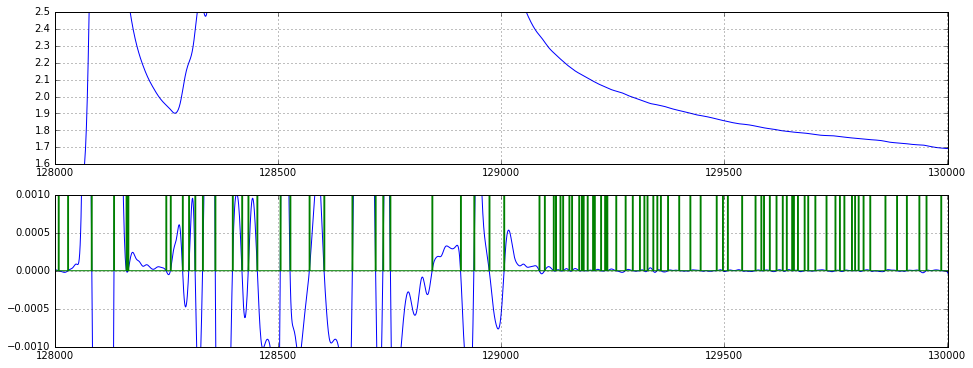

In [276]:
k = 97
s = 6

kernel = np.exp(-0.5*((np.arange(k) - k // 2) / s)**2) / s * 0.3989422804014327
#kernel /= kernel.sum()
z = np.convolve(y_true, kernel, mode = 'same')
#z = median_filter_1d(y_true, 48)
dy = 0.5*(z[2:] - z[:-2])
ddy = 0.5*(z[2:] - 2*z[1:-1] + z[:-2])

plt.figure(figsize = (16,6))
plt.subplot(2,1,1)
#plt.plot(y_true)
plt.plot(z)
plt.xlim(128000,130000)
plt.ylim(1.6,2.5)
plt.grid()

plt.subplot(2,1,2)
plt.plot(ddy)
plt.plot(np.hstack([0, ddy[1:] * ddy[:-1]]) <= 0)
plt.xlim(128000,130000)
plt.ylim(-0.001,0.001)
plt.grid()

In [265]:
ddy[1:] * ddy[:-1]

0.3989422804014327